In [1]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)
import pandas as pd
import numpy as np 

from codes.models.data_form.DataForm import DataTransfo_1SNP, PatientList
import matplotlib.pyplot as plt

In [2]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)


import numpy as np
import pandas as pd
import vcfpy
import pickle
from functools import partial
from tqdm import tqdm
import os
import time

from codes.models.data_form.DataSets import TabDictDataset

def get_paths_pheno_dicts(method, rollup_depth=None):
    if method == 'Paul':
        path_pheno_id_dict = f"/gpfs/commons/groups/gursoy_lab/pmeddeb/phenotype_embedding/vocab_dict/code2id_ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor.pickle"
        path_pheno_name_dict = f"/gpfs/commons/groups/gursoy_lab/pmeddeb/phenotype_embedding/vocab_dict/code2name_ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor.pickle"
        path_pheno_cat_dict = f"/gpfs/commons/groups/gursoy_lab/pmeddeb/phenotype_embedding/vocab_dict/code2cat_ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor.pickle"
    elif method == 'Abby':
        path_pheno_id_dict = '/gpfs/commons/groups/gursoy_lab/anewbury/embeddings/data/cohortId2ind.pickle'
        path_pheno_name_dict = '/gpfs/commons/groups/gursoy_lab/anewbury/embeddings/data/cohortId2name.pickle'
        path_pheno_cat_dict = '/gpfs/commons/groups/gursoy_lab/anewbury/embeddings/data/cohortId2name.pickle' #no separation between name and cat for Abby's method
    return path_pheno_id_dict, path_pheno_name_dict, path_pheno_cat_dict
def get_paths_pheno_file(method, rollup_depth=None, with_counts=False):
        if method == 'Paul':
            pheno_file  = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Paul/ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor.csv'
            pheno_file_tree = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Paul/ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor_tree.npy'
            pheno_file_tree_counts= f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Paul/ukbb_omop_rolled_up_depth_{rollup_depth}_closest_ancestor_tree_counts.npy'

        elif method == 'Abby':
            pheno_file = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Abby/phenotype_embedding_df_abby.csv'
            pheno_file_tree = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Pheno/Abby/phenotype_embedding_df_abby_tree.npy'
            pheno_file_tree_counts = None

        return pheno_file, pheno_file_tree, pheno_file_tree_counts
def get_paths_env_file():
        env_file = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/environmental_features/env_features.csv'
        return env_file
def get_paths_geno_file(CHR, SNP, binary_classes):
        label_dict = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Geno/{CHR}/{SNP}/label_dict_bclasses={binary_classes}.pkl'
        return label_dict

def map_array(tab1, tab2, i):
    indices = np.where(tab2==i)
    if len(indices[0]) == 0:
        return i
    else:
        return tab1[indices]

class DataTransfo_1SNP:
    def __init__(self, SNP, CHR, method='Paul', binary_classes=True, rollup_depth=4, pad_token='<PAD>', padding=True, load_data=True, save_data=False, 
                 remove_none=True, compute_features=True, data_share=1, prop_train_test=0.8, equalize_label=False, seuil_diseases=None,
                 decorelate=False, threshold_corr=1, threshold_rare=0, remove_rare=None, list_env_features=[], test=False, indices=None, list_pheno_ids=None, ld='no'):
        self.SNP = SNP
        self.CHR = CHR
        self.rollup_depth = rollup_depth
        self.pad_token = pad_token
        self.label_dict = None
        self.padding = padding
        self.path = "/gpfs/commons/datasets/controlled/ukbb-gursoylab/"
        self.load_data = load_data
        self.save_data = save_data
        self.remove_none = remove_none
        self.compute_features = compute_features
        self.data_share = data_share
        self.indices_train = None
        self.indices_test = None
        self.prop_train_test = prop_train_test
        self.method = method
        self.seuil_diseases = seuil_diseases
        self.equalize_label = equalize_label
        self.decorelate = decorelate
        self.threshold_corr = threshold_corr
        self.binary_classes = binary_classes
        self.threshold_rare = threshold_rare
        self.remove_rare = remove_rare
        path_pheno_id_dict, path_pheno_name_dict, path_pheno_cat_dict = get_paths_pheno_dicts(method, rollup_depth)
        self.pheno_file, self.pheno_file_tree, self.pheno_file_tree_counts = get_paths_pheno_file(method, rollup_depth)
        self.env_file = get_paths_env_file()
        self.geno_file = get_paths_geno_file(self.CHR, self.SNP, self.binary_classes)
        self.test = test
        self.ld=ld
        with open(path_pheno_id_dict, "rb") as f:
            self.pheno_id_dict = pickle.load(f)
        with open(path_pheno_name_dict, "rb") as f:
            self.name_dict = pickle.load(f)
        with open(path_pheno_cat_dict, "rb") as f:
            self.cat_dict = pickle.load(f)

        self.pheno_id_dict[0] = self.pad_token
        self.name_dict[0] = 'pad'
        self.cat_dict[0] = 'pad'
        self.vocab_size = len(self.pheno_id_dict)

        self.pheno_id_dict[self.pad_token]= 0
        self.name_dict[self.pad_token]= self.pad_token
        self.cat_dict[self.pad_token]= self.pad_token
        self.dicts = {'id':self.pheno_id_dict, 'name': self.name_dict, 'cat': self.cat_dict}
        self.list_env_features = list_env_features
        self.list_pheno_ids = list_pheno_ids
        self.indices = indices
        self.eid_list = None
        if self.indices != None:
            self.indices_test = indices[0]
            self.indices_train = indices[1]
        
    def build_name_file(self):
        decorelate_part = f'decorelate={self.decorelate}' if (not self.decorelate) else f'decorelate={self.decorelate}_thcorr={self.threshold_corr}_thrare={self.threshold_rare}_rmrare={self.remove_rare}'
        pheno_filter_snp_part = '' if (self.list_pheno_ids == None) else f'_filter={self.SNP}'
        
        name_file = f'PatientList_{self.SNP}_{decorelate_part}{pheno_filter_snp_part}.pkl'
        
        return name_file
        

    def get_patientlist(self):
        if self.load_data:
            start_time = time.time()
            print(f"loading data")
            # Open the file in binary write mode
            name_file = self.build_name_file()
            data_file = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Training/SNPS/{str(self.CHR)}/{self.SNP}/{self.method}/{name_file}'
           
            with open(data_file, 'rb') as file:
                patient_list = pickle.load(file)
            print(f"data_loaded in {time.time() - start_time} s")

            if  self.data_share != 1:
                patient_list.keep_share(self.data_share)
                self.indices_train = None
                self.indices_test = None
        else:
            print("building data")
            genectic_data = self.get_genetic_data()
            pheno_data_df = self.get_pheno_data()
            env_data_df = self.get_env_data()
            patient_list = PatientList(
                [self.get_eid_data(eid, pheno_data_df.get_group(eid), self.method) 
                for eid in tqdm(list(pheno_data_df.groups.keys())[:int(self.nb_eid * self.data_share)], desc="Processing", unit="group")], 
                self.pad_token, self.pheno_id_dict, self.list_env_features)
            
            print(len(patient_list))
            if self.remove_none:
                print("removing None values")
            patient_list.remove_none()
            if self.decorelate:
                patient_list.decorelate(self.threshold_corr, self.threshold_rare, self.remove_rare)
        
        if self.remove_none:
            print("removing None values")
            patient_list.remove_none()
        
        if self.padding:
            print("padding data")
            patient_list.padd_data()

        if self.seuil_diseases != None:
            patient_list.set_seuil_data(self.seuil_diseases)
            self.indices_train = None
            self.indices_test = None
        if self.equalize_label:
            patient_list.equalize_label()
        
        if self.compute_features:
            print("computing features")
            patient_list.get_nb_distinct_diseases_tot()
            patient_list.get_nb_max_distinct_diseases_patient()
            patient_list.get_max_count_same_disease()
            self.get_indices_train_test(nb_data=len(patient_list), prop_train_test=self.prop_train_test)
        if self.save_data and self.data_share==1: # saves only if all data have been processed
            print("saving data")
            data_dir = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Training/SNPS/{str(self.CHR)}/{self.SNP}/{self.method}/'
            name_file = self.build_name_file()
            data_file = os.path.join(data_dir, name_file)
            if not os.path.exists(data_dir):
                os.makedirs(data_dir)

            with open(data_file, 'wb') as file:
                # Use pickle.dump() to serialize and save the object to the file
                pickle.dump(patient_list, file)
        
        self.actualise_phenos(type='patient_list', patient_list=patient_list)

        
        return patient_list

    def get_pheno_data(self):
        start_time = time.time()
        if self.method == 'Paul':
            print('loading df Paul')
            if self.test:
                df = pd.read_csv(self.pheno_file, nrows=100)
                
            else:
                df = pd.read_csv(self.pheno_file)
            if self.list_pheno_ids != None:
                df = df[df['concept_id'].isin(self.list_pheno_ids)] # filter the dataFrame, only keep the eids that has one of the diseases
            #df['concept_id'] = df['concept_id'].map(self.pheno_id_dict) already done
            self.eid_list = list(df['eid'].unique())
            self.nb_eid = len(self.eid_list)
            df_grouped = df.groupby('eid')
        elif self.method == 'Abby':
            print('loading df Abby')
            if self.test:
                pheno_df = pd.read_csv(self.pheno_file, nrows=100)
            else:
                pheno_df = pd.read_csv(self.pheno_file)
            pheno_df.set_index(pheno_df.subject_id, inplace=True)
            pheno_df.drop('subject_id', axis=1, inplace=True)
            self.eid_list = list(pheno_df.index)
            self.nb_eid = len(self.eid_list)
            pheno_df.columns = pheno_df.columns.map(self.pheno_id_dict)
            df_grouped = pheno_df.groupby(pheno_df.index)
        print(f'df loaded in {time.time() - start_time} s for creating data')
        return df_grouped

    def get_env_data(self):
        df_env = pd.read_csv(self.env_file)
        self.env_df = df_env
        return df_env
    
    def get_eid_data(self, eid, df, method):
        if method == 'Paul':
            disease_sentence = np.unique((df['concept_id'].values))
            counts_sentence = [np.sum(df['condition_occurrence_count'][df['concept_id']==concept_id]) for concept_id in disease_sentence]
            label = self.label_dict.get(str(eid))
            #print(str(eid) in list(self.label_dict.keys()))
        elif method == 'Abby':
            df_t = df.transpose()
            df_t = df_t[df_t[eid]==1]
            disease_sentence = np.array(df_t.index)
            counts_sentence = np.ones(len(disease_sentence)) # put all the counts at one in Abby's case.
        label = self.label_dict.get(str(eid))
        #env features:
        dic_env_features_patient = {}            
        for feature in self.list_env_features:
            if np.sum(self.env_df['eid']==eid)==0:
                dic_env_features_patient[feature]=None
            else:
                dic_env_features_patient[feature] = self.env_df[self.env_df['eid']==eid].iloc[0][feature]
            

        patient = Patient(disease_sentence, counts_sentence, label, dic_env_features_patient)
        
        
        return patient

    def get_genetic_data(self):
        if os.path.exists(self.geno_file):
            with open(self.geno_file, 'rb') as file:
                label_dict = pickle.load(file)
        else:
            Vcf_file = self.path + f'Chr{self.CHR}/' + "filtered_snps.vcf"

            label_dict = {}

            vcf_reader = vcfpy.Reader(open(Vcf_file, 'r'))
            snp = None
            for record in vcf_reader:
                if record.ID[0] == self.SNP:
                    snp = record

            for call in snp.call_for_sample.values():
                sample_id = call.sample.split('_')[0]
                gt_value = call.data.get('GT')

                if gt_value == '0/0':
                    label = 0
                elif gt_value == '0/1':
                    label = 1
                elif gt_value == '1/1':
                    if self.binary_classes:
                        label = 1
                    else :
                        label = 2
                else:
                    label = None  # Handle other cases if needed
                
                if label is not None:
                    label_dict[sample_id] = label
            os.makedirs(os.path.dirname(self.geno_file), exist_ok=True)
            with open(self.geno_file, 'wb') as file:
                    pickle.dump(label_dict, file)

        self.label_dict = label_dict
        return label_dict

    def get_indices_train_test(self, nb_data=None, prop_train_test=0.8):
        if type(self.indices_train) != np.ndarray:
            indices = np.arange(nb_data)
            np.random.shuffle(indices)
            self.indices_train = indices[:int(nb_data*prop_train_test)]
            self.indices_test = indices[int(nb_data*prop_train_test):]
        return self.indices_train, self.indices_test
    
    def get_tree_data(self, with_env=True, with_counts=False, load_possible=True, only_relevant=False):
        if self.list_pheno_ids == None:
            if self.method == 'Abby':
                pheno_data = np.load(self.pheno_file_tree)
                eids = pheno_data[:,0]
                nb_phenos = pheno_data.shape[1] - 1
                pheno_data_tot = np.zeros((pheno_data.shape[0], nb_phenos+1+len(self.list_env_features))) if with_env else np.zeros((pheno_data.shape[0], nb_phenos+1))
                pheno_data_tot[:, :pheno_data.shape[1]] = pheno_data


                
            
            if self.method == 'Paul':
                if self.list_env_features == []:
                    with_env = False
                pheno_file_tree = self.pheno_file_tree_counts if with_counts else self.pheno_file_tree
                if load_possible and os.path.exists(pheno_file_tree):
                    pheno_data = np.load(self.pheno_file_tree)
                    eids = pheno_data[:,0]
                    nb_phenos = pheno_data.shape[1] - 1
                    
                    pheno_data_tot = np.zeros((pheno_data.shape[0], nb_phenos+1+len(self.list_env_features))) if with_env else np.zeros((pheno_data.shape[0], nb_phenos+1))
                    pheno_data_tot[:, :pheno_data.shape[1]] = pheno_data

                    
                else:
                    pheno_df = pd.read_csv(self.pheno_file)
                    eids = np.unique( np.array(list(pheno_df['eid'])))
                    nb_phenos = np.max(pheno_df['concept_id'])
                    pheno_data_tot = np.zeros((len(eids), nb_phenos+1+len(self.list_env_features)), dtype=int) if with_env else  np.zeros((len(eids), nb_phenos+1), dtype=int) 

                    grouped = pheno_df.groupby('eid')

                    def get_sum_counts(group, i):
                        return np.sum(group['condition_occurrence_count'][group['concept_id']==i])

                    def get_data(with_counts, group):
                        if with_counts:
                            get_sum_counts_par = np.vectorize(partial(get_sum_counts, group))
                            arr = np.array(group['concept_id'].unique())
                            return arr, get_sum_counts_par(arr)
                        else:
                            return np.array(group['concept_id'].unique())
                        
                    get_data = partial(get_data, with_counts)       
                    data_list = grouped.apply(get_data)

                    if with_counts:
                        for k, (diseases, counts) in enumerate(data_list):
                            pheno_data_tot[k,np.array(diseases)] = counts
                    else:
                        for k, diseases in enumerate(data_list):
                            pheno_data_tot[k,np.array(diseases)] = 1
                    


                    if self.save_data:
                        data = pheno_data_tot
                        np.save(self.pheno_file_tree, arr = data[:, :1+ nb_phenos])

            if with_env:
                env_df = pd.read_csv(self.env_file)[['eid'] + self.list_env_features]
                env_df.set_index('eid', inplace=True)
            label_dict = self.get_genetic_data()
            indices = np.isin(eids,env_df.index) & (np.isin(eids, list(label_dict.keys()))) if with_env else np.isin(eids, list(label_dict.keys()))

            env = []
            labels = []
            for eid in eids[indices]:
                if with_env:
                    env.append(np.array(env_df.loc[eid]))
                labels.append(label_dict[str(eid)])


            env = np.array(env)
            labels = np.array(labels)
            pheno_data_tot = pheno_data_tot[indices]
            if with_env :
                pheno_data_tot[:, 1 + nb_phenos:] = env


            
            return pheno_data_tot[:, 1:], labels, 1+nb_phenos, self.list_env_features

        else:
            if self.method == 'Paul':
                pheno_df = pd.read_csv(self.pheno_file)
                pheno_df_filtered = pheno_df[pheno_df['concept_id'].isin(self.list_pheno_ids)]
                eid_list_filtered = np.unique( np.array(list(pheno_df_filtered['eid'])))
                eid_list = np.unique( np.array(list(pheno_df['eid'])))

                nb_phenos = np.max(pheno_df['concept_id'])

                grouped = pheno_df_filtered.groupby('eid') if only_relevant else pheno_df.groupby('eid')

                pheno_id_dict = self.pheno_id_dict
                pheno_id_reverse = {value: key for key, value in pheno_id_dict.items()}

                dic_map_pheno_old_new = { self.list_pheno_ids[i]:i+1 for i in range(len(self.list_pheno_ids))}

                pheno_id_dict_new = {pheno_id_reverse[pheno_id]: i+1 for i,pheno_id in enumerate(self.list_pheno_ids)}
                pheno_id_dict_new[max(pheno_id_dict_new.keys())+1] = len(self.list_pheno_ids)+1
                self.name_dict[max(pheno_id_dict_new.keys())] = 'additional disease'
                self.name_dict = {key:self.name_dict[key] for key in pheno_id_dict_new.keys()}
                self.cat_dict[max(pheno_id_dict_new.keys())] = 'additional disease'
                self.cat_dict = {key:self.cat_dict[key] for key in pheno_id_dict_new.keys()}
                
                self.pheno_dict = pheno_id_dict_new

                def map_values(val):
                    return dic_map_pheno_old_new[val]
                map_values = np.vectorize(map_values)

                nb_phenos_interest = len(self.list_pheno_ids)
                if only_relevant:
                    res = np.zeros((len(eid_list), nb_phenos_interest), dtype=int)
                else:
                    res = np.zeros((len(eid_list), nb_phenos), dtype=int)
                print(nb_phenos)
                
                data_list  = [np.array(grouped.get_group(eid)['concept_id'].unique())
                        for eid in eid_list_filtered]
                for k, diseases in enumerate(data_list):
                    if only_relevant:
                        res[k,map_values(diseases)-1] = 1
                    else:
                        res[k, diseases-1] = 1
                if only_relevant:
                    columns = np.arange(1, nb_phenos_interest+1)
                else:
                    columns = np.arange(1, nb_phenos+1)
                print(len(columns))
                print(res.shape)
                pheno_df = pd.DataFrame(data=res, columns=columns)
                pheno_df.insert(0, 'eid', eid_list)
                if only_relevant:
                    pheno_df[nb_phenos_interest+1] = np.ones(len(pheno_df), dtype=int)
                

        env_df = pd.read_csv(self.env_file)
        env_df.set_index('eid', inplace=True)
        pheno_df.set_index('eid', inplace=True)
        list_features_env = self.list_env_features if with_env else []
        df_tot = pheno_df.join(env_df[list_features_env], on=pheno_df.index, rsuffix='') if with_env else pheno_df



        
        label_dict = self.get_genetic_data()
        df_labels = pd.DataFrame(list(label_dict.items()), columns=['eid', 'label'])
        df_labels.set_index('eid', inplace=True)
        df_labels.index = df_labels.index.astype(int)
        df_tot_label = df_tot.join(df_labels, on = df_tot.index, rsuffix='')

        if self.remove_none:
            df_tot_label = df_tot_label[df_tot_label['label'].notna()]
        columns = df_tot_label.columns
        indice_env = len(pheno_df.columns)
        cols_env = columns[indice_env:]
        #df_tot_label = df_tot_label.astype(int)
        pheno_data = df_tot_label.to_numpy()


        if self.list_pheno_ids != None:
            return pheno_data[:,:-1], pheno_data[:, -1], indice_env, cols_env, len(eid_list_filtered)
    

        return pheno_data[:,:-1], pheno_data[:, -1], indice_env, cols_env, df_tot_label 

    def get_data_tabtransfo(self, train_test=False, patient_list=None, actualise_phenos=True):
        keys = ['diseases', 'counts'] + self.list_env_features
        self.dic_list_patients = {key:[] for key in keys }

        if self.load_data:
            data_dir = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Training/SNPS/{str(self.CHR)}/{self.SNP}/{self.method}/'
            if self.decorelate:
                name_file = f'dic_data_{self.SNP}_decorelate={self.decorelate}_thcorr={self.threshold_corr}_thrare={self.threshold_rare}_rmrare={self.remove_rare}.pkl'
            else:
                name_file = f'dic_data_{self.SNP}_decorelate={self.decorelate}.pkl'
            filename = data_dir + name_file
            with open(filename, 'rb') as file:
                dic_list_patients_loaded = pickle.load(file)
            for key in keys:
                self.dic_list_patients[key] = dic_list_patients_loaded[key]
            
            

        else:
            
            if patient_list == None:
                patient_list = self.get_patientlist()

            
            for patient in tqdm(patient_list, desc='Processing', unit='group') :
                self.dic_list_patients['diseases'].append(patient.diseases_sentence)
                self.dic_list_patients['counts'].append(patient.counts_sentence)
                self.dic_list_patients['SNP_label'].append(patient.SNP_label)
                for key, value in patient.dic_env_features.items():
                    self.dic_list_patients[key].append(value)


            if self.save_data:
                data_dir = f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/Training/SNPS/{str(self.CHR)}/{self.SNP}/{self.method}/'
                if self.decorelate:
                    name_file = f'dic_data_{self.SNP}_decorelate={self.decorelate}_thcorr={self.threshold_corr}_thrare={self.threshold_rare}_rmrare={self.remove_rare}.pkl'
                else:
                    name_file = f'dic_data_{self.SNP}_decorelate={self.decorelate}.pkl'
                filename = data_dir + name_file
                with open(filename, 'wb') as file:
                    pickle.dump(self.dic_list_patients, file)

        if actualise_phenos:
            self.actualise_phenos(type='dic_tab', dic_list_patients=self.dic_list_patients)
        return self.dic_list_patients

    def actualise_phenos(self, type='patient_list', patient_list=None, dic_list_patients=None):
        diseases_present = np.zeros(len(self.pheno_id_dict), dtype=bool)

        if type=='patient_list':
            for patient in patient_list:
                diseases_present[patient.diseases_sentence] = True
        elif type=='dic_tab':
            for list_diseases in dic_list_patients['diseases']:
                diseases_present[np.array(list_diseases)] = True
        phenos_ex = np.where(diseases_present==True)[0]
        phenos_new = np.zeros(len(diseases_present), dtype=int)
        phenos_new[diseases_present] = np.arange(len(phenos_ex))
        if type=='patient_list':
            for patient in patient_list:
                patient.diseases_sentence = phenos_new[patient.diseases_sentence]
        elif type=='dic_tab':
            for k, list_diseases in enumerate(dic_list_patients['diseases']):
                dic_list_patients['diseases'][k] = phenos_new[np.array(list_diseases)]
        id_dict = {0:self.pad_token}
        cat_dict = {0 : 'pad'}
        name_dict = {0 : 'pad'}
        for key in self.pheno_id_dict:
            pheno_id = self.pheno_id_dict[key]
            if phenos_new[pheno_id] != 0 :
                id_dict[key] = phenos_new[pheno_id] 
                cat_dict[key] = self.cat_dict[key]
                name_dict[key] = self.name_dict[key]
        self.pheno_id_dict = id_dict
        self.cat_dict = cat_dict
        self.name_dict = name_dict
        self.dicts = {'id':self.pheno_id_dict, 'name': self.name_dict, 'cat': self.cat_dict, 'diseases_present':diseases_present}


    @staticmethod
    def equalize_label(data, labels):
        nb_zeros = np.sum(labels==0)
        nb_ones = np.sum(labels==1)
        minor_label = 1 if nb_ones <= nb_zeros else 0
        major_label = 1 - minor_label
        data_minor = data[labels==minor_label]
        data_major = data[labels ==major_label][:len(data_minor)]
        data = np.concatenate([data_minor, data_major], axis=0)
        labels = np.array([minor_label]*len(data_minor) + [major_label]*len(data_major))
        return data, labels
        

class Patient:
    def __init__(self, diseases_sentence, counts_sentence, label, dic_env_features=None):
        self.diseases_sentence = diseases_sentence
        self.counts_sentence = counts_sentence
        self.SNP_label = label
        self.dic_env_features = dic_env_features

        self.nb_max_distinct_diseases_patient = None
        self.nb_max_counts_same_disease = None
        self.nb_distinct_diseases_ini = len(self.diseases_sentence)
        self.nb_distinct_diseases = self.get_nb_distinct_diseases
        self.nb_counts_distinct_diseases = len(self.counts_sentence)
        self.hasnone = False
        self.see_hasnone()

    def see_hasnone(self):
        if self.SNP_label==None:
            self.hasnone = True
        else:
            for feature in self.dic_env_features.keys():
                if self.dic_env_features[feature]==None:
                    self.hasnone=True

    @property
    def nb_distinct_diseases_actual(self):
        return len(self.diseases_sentence)
    
    @property
    def nb_counts_distinct_diseases_actual(self):
        return len(self.counts_sentence)

    @property
    def get_nb_distinct_diseases(self):
        diseases_sentence = np.array(self.diseases_sentence)
        self.nb_distinct_diseases = len(diseases_sentence[diseases_sentence != 0])
        return self.nb_distinct_diseases
    
    def padd_patient(self, nb_max_distinct_disease, padding_item):
        self.diseases_sentence = np.concatenate([self.diseases_sentence, np.full(nb_max_distinct_disease-self.nb_distinct_diseases_actual, padding_item)])
        self.counts_sentence = np.concatenate([self.counts_sentence, np.zeros(nb_max_distinct_disease-self.nb_counts_distinct_diseases_actual)]).astype(int)
        return nb_max_distinct_disease-self.nb_distinct_diseases# to inform on sparcity
    def unpadd_patient(self, padding_item):
        self.diseases_sentence = self.diseases_sentence[self.diseases_sentence!= padding_item]
        self.counts_sentence = self.counts_sentence[self.counts_sentence!= padding_item]

    def get_vector(self, nb_max_diseases_sentence):
        patient_grouped = list(zip(self.diseases_sentence, self.counts_sentence))

        # Sort element according to the first list
        patient_group_sorted = sorted(patient_grouped, key=lambda x: x[0])
        # Retrieve the two sorted list
        diseases_sentence_sorted, counts_sentence_sorted = map(np.array, zip(*patient_group_sorted))
        # create patient vector
        vector_patient = np.zeros(nb_max_diseases_sentence)
        vector_patient[diseases_sentence_sorted-1] = counts_sentence_sorted
        self.vector_patient = vector_patient
        return vector_patient

    def get_tree_data(self, nb_max_diseases_sentence, list_env_features=[]):
        res_diseases = np.zeros(nb_max_diseases_sentence)
        res_diseases[self.diseases_sentence] = 1
        if len(list_env_features) > 0:
            print(self.dic_env_features['age'])
            tab_env = np.array([self.dic_env_features[key] for key in list_env_features])
            return np.concatenate([res_diseases, tab_env])
        return res_diseases
    
    def delete_phenos(self, pheno_map_final, tab_reverse_pheno_ex_new):
        diseases_sentence_ini = self.diseases_sentence
        self.diseases_sentence =  np.unique(pheno_map_final(np.array(diseases_sentence_ini)))
        self.diseases_sentence = self.diseases_sentence[self.diseases_sentence !=0] # to get rid of the zeros(padding or removal)
        group_pheno_id_list = [tab_reverse_pheno_ex_new[i] for i in self.diseases_sentence]
        self.counts_sentence = [np.max(np.array(self.counts_sentence)[np.where(np.isin(diseases_sentence_ini,group_pheno_id_list[0][0]))[0]]) for group_pheno_id in group_pheno_id_list]


            
class PatientList:
    def __init__(self, list_patients, padding_item=0, pheno_id_dict=None, list_env_features=[]):
        self.patients_list = list_patients
        self.padding_item = padding_item
        self.nb_distinct_diseases_tot = None
        self.nb_max_counts_same_disease = None
        self.nb_max_distinct_diseases_patient = None
        self.label_vector = None
        self.is_padded = False
        self.pheno_id_dict = pheno_id_dict
        self.sparsity = None
        self.seuil = None
        self.share = 1
        self.list_env_features = list_env_features
        

        

    def __len__(self):
        return len(self.patients_list)
    def __getitem__(self, idx):
        return self.patients_list[idx]
    
    def keep_share(self, share):
        if self.share == share:
            pass
        else:
            n = int(share * len(self))
            self.patients_list = self.patients_list[:n]
            self.share = share
    
    def get_nb_max_distinct_diseases_patient(self):
        self.nb_max_distinct_diseases_patient = np.max(np.array([patient.nb_distinct_diseases for patient in self.patients_list]))
        return self.nb_max_distinct_diseases_patient
  
    def get_max_count_same_disease(self):
        self.nb_max_counts_same_disease = max([max(patient.counts_sentence) for patient in self.patients_list])+1 #+1 because of zero counts (padding)
        return self.nb_max_counts_same_disease
    
    def get_nb_distinct_diseases_tot(self):
        self.nb_distinct_diseases_tot = max([max(patient.diseases_sentence) for patient in self.patients_list])+1 #+1 because of the zero padding

        return self.nb_distinct_diseases_tot
    def get_labels_vector(self):
        self.label_vector = np.array([patient.SNP_label for patient in self.patients_list])
        return self.label_vector
    
    def remove_none(self):
        patient_list = []
        for patient in self.patients_list:
            if not patient.hasnone:
                patient_list.append(patient)
            
        self.patients_list = patient_list


    def get_transformer_data(self, indices_train, indices_test): # transform the patients list in a tuple (distinct_diseases, counts_sentences) list
        transformer_dataset_train = [(patient.diseases_sentence, patient.counts_sentence, patient.SNP_label) for patient in np.array(self.patients_list)[indices_train]]
        transformer_dataset_test = [(patient.diseases_sentence, patient.counts_sentence, patient.SNP_label) for patient in np.array(self.patients_list)[indices_test]]

        return transformer_dataset_train,transformer_dataset_test
    
    def padd_data(self):
        if self.is_padded == True:
            pass
        else:
            if self.nb_max_distinct_diseases_patient==None:
                self.get_nb_max_distinct_diseases_patient()
            padded_data_count = 0
            for patient in self.patients_list:
                padded_data_count += patient.padd_patient(self.nb_max_distinct_diseases_patient, self.padding_item)
            self.sparsity = padded_data_count / (len(self)*self.nb_max_distinct_diseases_patient)
            self.is_padded = True

    def get_matrix_data(self):
        if self.nb_max_distinct_diseases_patient==None:
            nb_distinct_diseases_patient = self.get_nb_max_distinct_diseases_patient()
        patient_list_matrix = np.zeros((len(self),nb_distinct_diseases_patient))
        for i,patient in enumerate(self.patients_list):
            patient_list_matrix[i,:] = patient.get_vector(nb_distinct_diseases_patient)
        
        return patient_list_matrix, self.get_labels_vector()
    
    def get_tree_data(self, with_env=False):
        if self.nb_distinct_diseases_tot==None:
            nb_distinct_diseases_tot = self.get_nb_distinct_diseases_tot()
        label_vector = self.get_labels_vector()
        if with_env:
            return ([patient.get_tree_data(self.nb_distinct_diseases_tot, list_env_features=self.list_env_features) for patient in self.patients_list], label_vector)
        else:
            return ([patient.get_tree_data(self.nb_distinct_diseases_tot, list_env_features=[]) for patient in self.patients_list], label_vector)
    
    def compute_features(self):
        self.get_nb_distinct_diseases_tot()
        self.get_max_count_same_disease()
        self.get_nb_max_distinct_diseases_patient()

    def set_seuil_data(self, seuil):
        new_patient_list = []
        for patient in self.patients_list:
            if patient.nb_counts_distinct_diseases <= seuil:
                new_patient_list.append(patient)
        self.patients_list = new_patient_list
        self.compute_features()

    def get_major_label(self):
        label_vector = self.get_labels_vector()
        nb_zeros = np.sum(label_vector==0)
        nb_ones = np.sum(label_vector==1)
        if nb_zeros >= nb_ones:
            return 0
        else:
            return 1
        
    def equalize_label(self):
        major_label = self.get_major_label()
        nb_minor_label = np.sum(self.label_vector!=major_label)
        counts_major_label = 0
        new_patient_list = []
        for patient in self.patients_list:
            if patient.SNP_label != major_label:
                new_patient_list.append(patient)
            else:
                if counts_major_label < nb_minor_label:
                    new_patient_list.append(patient)
                    counts_major_label +=1
        self.patients_list = new_patient_list
        self.compute_features()

    def split_labels(self):
        patient_label_zero = []
        patient_label_one = []
        for patient in self.patients_list:
            if patient.SNP_label == 0:
                patient_label_zero.append(patient)
            else:
                patient_label_one.append(patient)
        return patient_label_zero, patient_label_one
    
    @staticmethod
    def remove_pheno(indices_pheno_null_variance, indices_phenos_rare, indices_pheno_one_class, remove_rare=None):
        if remove_rare==None:
            return indices_pheno_null_variance
        elif remove_rare == 'all':
            return np.unique(np.concatenate([indices_pheno_null_variance, indices_phenos_rare]))
        elif remove_rare == 'one_class':
            tab_phenos_rare_and_one_class = np.intersect1d(indices_pheno_one_class, indices_phenos_rare) 
            return np.unique(np.concatenate([indices_pheno_null_variance, tab_phenos_rare_and_one_class]))

    def decorelate(self, threshold_corr, threshold_rare, remove_rare, dicts=None):
        print('decorelate the data set')
        pheno_tree, labels = self.get_tree_data()
        pheno_tree = np.array(pheno_tree)
        nb_occ = np.sum(pheno_tree, axis=0)
        self.indices_pheno_null_variance =np.argwhere(np.var(pheno_tree, axis=0) ==0)
        self.indices_pheno_rare = np.argwhere(nb_occ < threshold_rare)
        #pheno_tree = pheno_tree[ :, np.var(pheno_tree, axis=0)!=0] #get rid of the phenotypes that has a null variance
        def get_labels(col):
            return len(np.unique(labels[col==1]))-1
        counts_labels = np.apply_along_axis(get_labels, axis =0, arr=pheno_tree)
        self.indices_pheno_one_class = np.argwhere(counts_labels==0)

        self.indices_pheno_remove = PatientList.remove_pheno(self.indices_pheno_null_variance, self.indices_pheno_rare, self.indices_pheno_one_class, remove_rare)
        print('calcul_corr')
        start_time_corr = time.time()
        corr = np.corrcoef(pheno_tree, rowvar=False)
        mask = np.tri(corr.shape[0], k=0, dtype=bool)
        corr[mask] = None
        print(f' corr computed in {time.time() - start_time_corr}s')
        tab_phenos_delete, tab_phenos_keep= np.where(corr >= threshold_corr)
        self.fully_correlated_phenos = list(zip(tab_phenos_delete, tab_phenos_keep))
        list_indices_phenos_ex = np.arange(0, self.nb_distinct_diseases_tot+1)
        list_indice_phenos_new = np.arange(0, self.nb_distinct_diseases_tot+1)
        list_indice_phenos_new[self.padding_item] = 0
        print('building correspondance')
        ##building the correspondance between the phenotype that will be deleted and those associated who remains
        for k, pheno_delete in enumerate(np.unique(tab_phenos_delete)):
            pheno_keep = tab_phenos_keep[np.min(np.where(tab_phenos_delete==pheno_delete))]
            list_indice_phenos_new[pheno_delete] = pheno_keep
            list_indice_phenos_new[list_indice_phenos_new == pheno_delete] = pheno_keep

        self.list_indice_phenos_new = np.array(list_indice_phenos_new)
        self.list_indice_phenos_ex = np.array(list_indices_phenos_ex)
        self.indices_phenos_present= np.arange(0, len(np.unique(self.list_indice_phenos_new)))
        pheno_map_fun_new = np.vectorize( partial(map_array, self.list_indice_phenos_new, self.list_indice_phenos_ex))
        pheno_map_fun_reordered = np.vectorize(partial(map_array, self.indices_phenos_present, np.unique(self.list_indice_phenos_new)))


        self.indices_pheno_remove = pheno_map_fun_reordered(pheno_map_fun_new(self.indices_pheno_remove))
        pheno_map_fun_delete = np.vectorize(partial(map_array, np.zeros(len(np.unique(self.indices_pheno_remove))), np.unique(self.indices_pheno_remove)))
        self.list_indice_phenos_new = pheno_map_fun_reordered(self.list_indice_phenos_new)

        self.list_indice_phenos_new = pheno_map_fun_delete(self.list_indice_phenos_new)
        new_len = len(self.list_indice_phenos_new[self.list_indice_phenos_new != 0])
        self.list_indice_phenos_new = pheno_map_fun_delete(self.list_indice_phenos_new)
        self.indices_phenos_present= np.arange(0, len(np.unique(self.list_indice_phenos_new)))
        pheno_map_fun_reordered_2 = np.vectorize(partial(map_array, self.indices_phenos_present, np.unique(self.list_indice_phenos_new)))
        self.list_indice_phenos_new = pheno_map_fun_reordered_2(self.list_indice_phenos_new )

        pheno_map_final = np.vectorize(partial(map_array, self.list_indice_phenos_new , self.list_indice_phenos_ex ))
            
        self.tab_reverse_pheno_ex_new = [np.where(self.list_indice_phenos_new==i) for i in np.unique(self.list_indice_phenos_new)]



        print('update patient_list')
        start_time_patient = time.time()
        [patient.delete_phenos(pheno_map_final, self.tab_reverse_pheno_ex_new) for patient in 
            tqdm(self.patients_list, desc="Processing", unit="group")]
        print(f'patients computed in {time.time() - start_time_patient}s')

        self.is_padded = False
        self.nb_max_distinct_diseases_patient = None

        self.padd_data()

        if dicts!= None:
            pheno_id_dict = dicts['id']
            pheno_name_dict = dicts['name']
            pheno_cat_dict = dicts['cat']
            pheno_id_dict_reverse = { pheno_id_dict[key]:key for key in pheno_id_dict.keys()}
            keys = pheno_id_dict.keys()
            for key in keys:
                if pheno_id_dict[key] not in self.indices_pheno_remove:
                    pheno_id_dict[key] = self.list_indice_phenos_new[pheno_id_dict[key]]
                    pheno_name_dict[key] = key
                    pheno_cat_dict[key] = key
                else:
                    pheno_id_dict.pop(key)
                    pheno_name_dict.pop(key)
                    pheno_cat_dict.pop(key)




                

In [3]:
### data constants:
CHR = 1
SNP = 'rs673604'
pheno_method = 'Abby' # Paul, Abby
rollup_depth = 4
Classes_nb = 2 #nb of classes related to an SNP (here 0 or 1)
vocab_size = None # to be defined with data
ld = 'no'
padding_token = 0
prop_train_test = 0.8
load_data = True
save_data = True
remove_none = False
decorelate = False
equalize_label = False
threshold_corr = 0.8
threshold_rare = 1000
remove_rare = 'all' # None, 'all', 'one_class'
compute_features = True
padding = True
list_env_features = []
list_phenos_ids = None#list(np.load('/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/phewas/list_associations_snps/rs673604_paul.npy'))
### data format
batch_size = 20
data_share = 1

In [4]:
dataT = DataTransfo_1SNP(SNP=SNP,
                         CHR=CHR,
                         method=pheno_method,
                         padding=padding,  
                         pad_token=padding_token, 
                         load_data=load_data, 
                         save_data=save_data, 
                         compute_features=compute_features,
                         prop_train_test=prop_train_test,
                         remove_none=remove_none,
                         equalize_label=equalize_label,
                         rollup_depth=rollup_depth,
                         decorelate=decorelate,
                         threshold_corr=threshold_corr,
                         threshold_rare=threshold_rare,
                         remove_rare=remove_rare, 
                         list_env_features=list_env_features,
                         data_share=data_share,
                         list_pheno_ids=list_phenos_ids,
                         ld=ld)
#patient_list = dataT.get_patientlist()''


In [5]:
data, labels, indices_env, env_features= dataT.get_tree_data(with_env=False, with_counts=False, load_possible=True, only_relevant=True)

In [22]:
data.shape

(405084, 1717)

In [6]:
data_equalized, labels_equalized = DataTransfo_1SNP.equalize_label(data, labels)

In [256]:
data_save, labels_save = data, labels

### Find a specific disease name

In [8]:
id = 92
dic_pheno_id = dataT.pheno_id_dict
name_dict = dataT.name_dict
reverse = {value:key for key, value in dic_pheno_id.items()}
name_dict[reverse[id]]

'Vitreous floaters'

### Analyse of the correlations

In [5]:
data, labels = data, labels # keep only relevant samples

In [9]:

list_corr = np.array([np.corrcoef(labels, data[:,i])[0,1] for i in range(data.shape[1]-1)])

/gpfs/commons/home/mstoll/anaconda3/envs/phewas/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gpfs/commons/home/mstoll/anaconda3/envs/phewas/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [9]:
plt.plot(list_corr, 'o')

NameError: name 'plt' is not defined

### Analyse of the F1

In [285]:
data_equalized = data_equalized[:, :-1]
data = data[:, :-1]

In [7]:
def get_F_pheno(data, labels, pheno_nb):    
    labels_1 = labels[data[:,pheno_nb]==1]
    labels_0 = labels[data[:,pheno_nb]==0]
    P0 = np.sum(labels_0==1)/len(labels_0)
    P1 = np.sum(labels_1==1)/len(labels_1)
    F0 = max(P0, 1-P0)
    F1 = max(P1, 1-P1)
    return P0, P1
def get_plots_F(data, labels):
    
    get_risk_pheno = partial(get_F_pheno, data, labels)
    frequencies = np.sum(data, axis=0) / len(data)
    seuil_frequencies = -1
    indices = frequencies*len(data) > seuil_frequencies
    proba_mean = max(np.sum(labels==0)/len(labels), 1-np.sum(labels==0)/len(labels))
    phenos = np.arange(len(data[0]))[indices]
    Fs = np.array(list(map(get_risk_pheno, phenos)))

    fig, axes = plt.subplots(1, 2, figsize = (10, 10))
    axes[0].plot(Fs[:,0], 'o')
    axes[0].plot(Fs[:, 1], 'o')
    axes[0].axhline(proba_mean)
    log_freq = np.log(frequencies*len(data)+1)[indices]
    color_values = log_freq

    diff_p = np.abs(Fs[:,0]-Fs[:,1]) *100
    axes[1].scatter(np.arange(len(diff_p)), diff_p, c= color_values , cmap='viridis')

    fig = plt.subplots(figsize=(10, 10))
    plt.scatter(np.arange(len(diff_p)), diff_p, c=color_values, cmap='viridis')
    plt.colorbar()
    return Fs


/scratch/ipykernel_5517/3330116416.py:5: RuntimeWarning: invalid value encountered in scalar divide
  P1 = np.sum(labels_1==1)/len(labels_1)


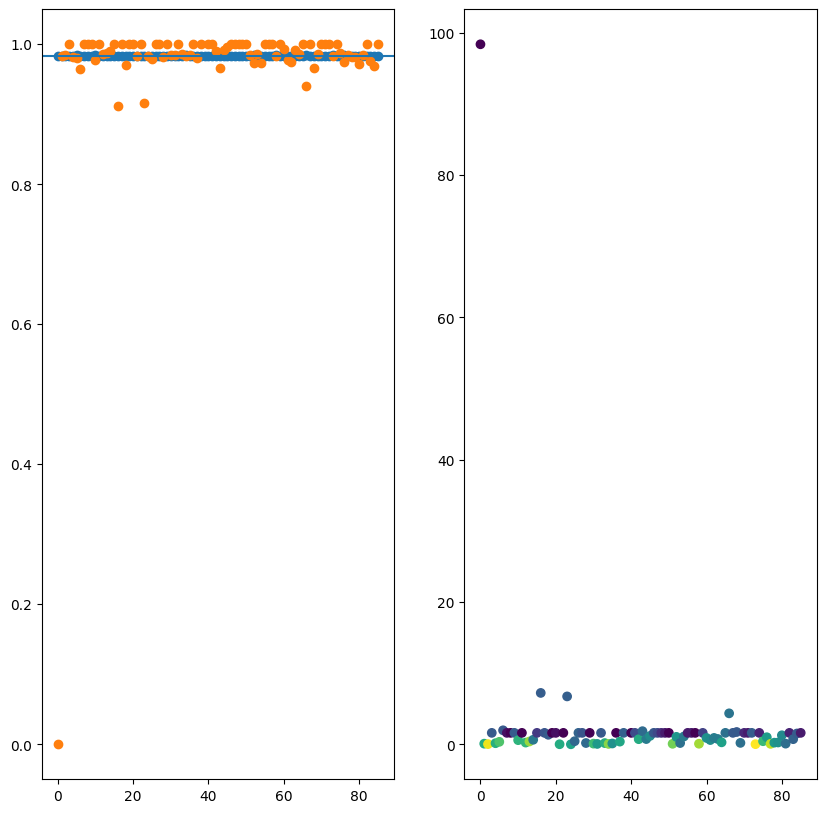

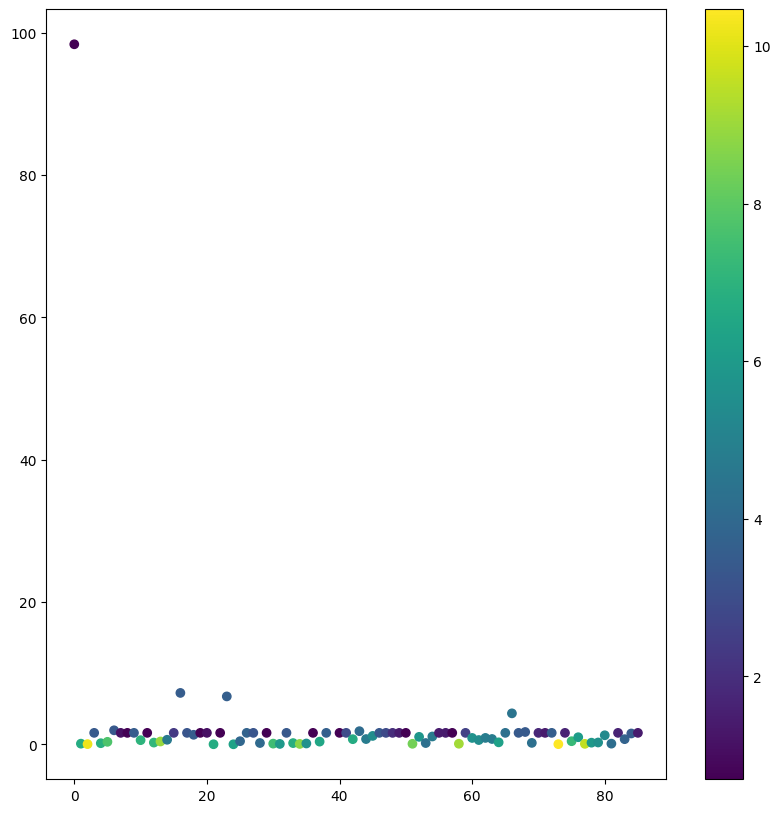

In [308]:
Fs = get_plots_F(data, labels)


In [313]:
Fs[72]

array([0.9839368, 1.       ])

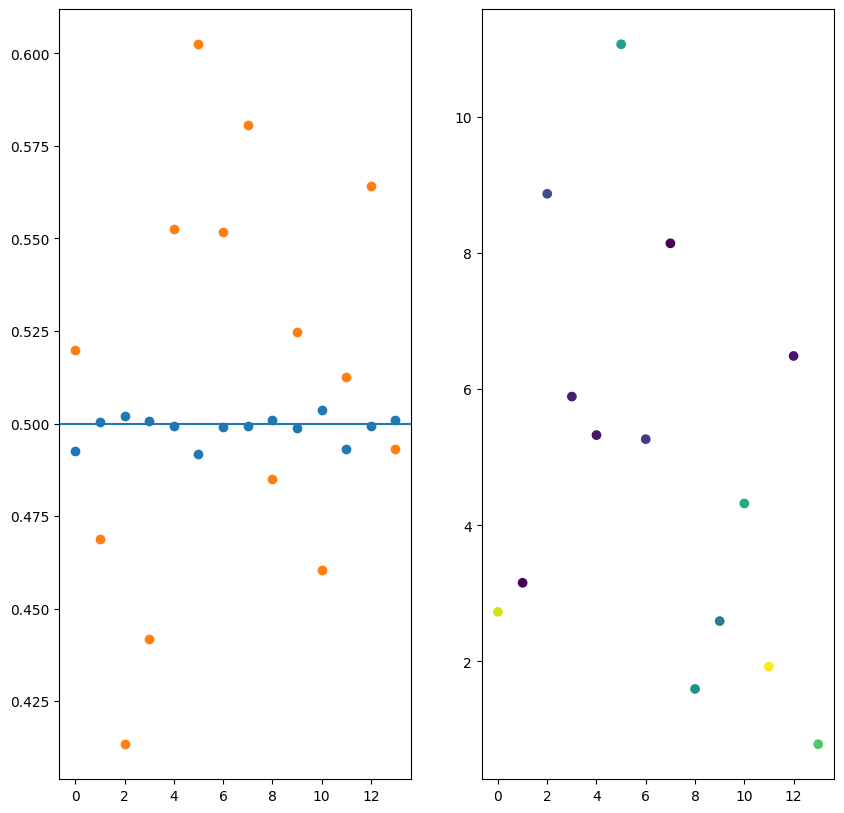

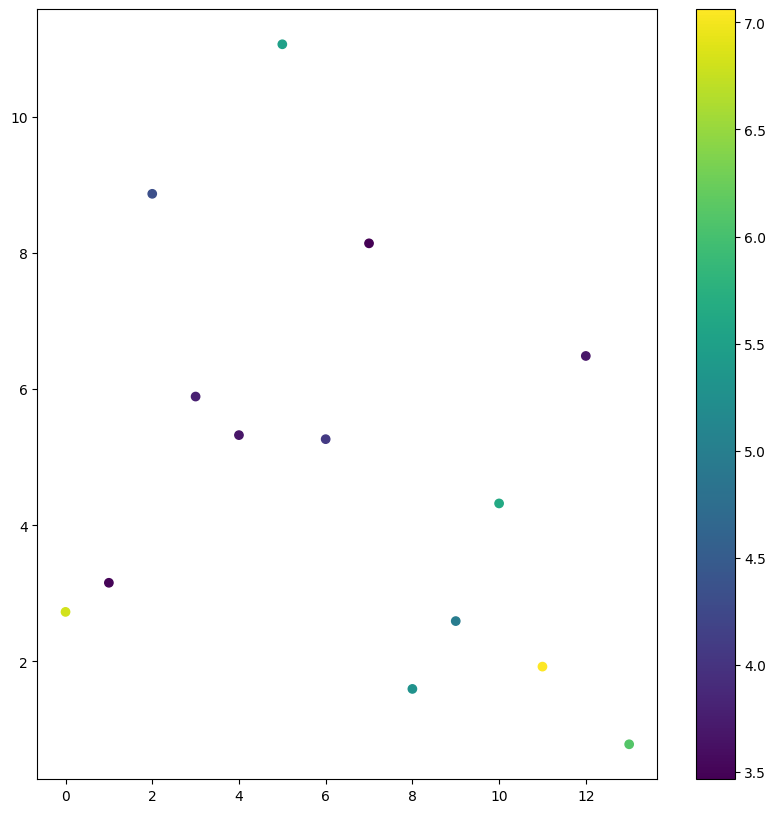

In [304]:
get_plots_F(data_equalized, labels_equalized)

### Tests

In [86]:
            
df = pd.read_csv(dataT.pheno_file, nrows=1000000)
#df_filtered =  df[df['concept_id'].isin(dataT.list_pheno_ids)]

#df['concept_id'] = df['concept_id'].map(dataT.pheno_id_dict) already done
dataT.eid_list = list(df['eid'].unique())
dataT.nb_eid = len(dataT.eid_list)
df_grouped = df.groupby('eid')

In [87]:
eid = 1000035

In [88]:
df = df_grouped.get_group(eid)

In [104]:
df

,Unnamed: 0,eid,condition_occurrence_count,concept_id
53885,53885,1000035,1,5
74433,74433,1000035,1,6
166878,166878,1000035,1,7
166879,166879,1000035,1,7
167998,167998,1000035,1,8
167999,167999,1000035,1,8
174142,174142,1000035,1,9
174143,174143,1000035,1,9
176521,176521,1000035,1,10
176522,176522,1000035,1,10


In [103]:

#env features:

    



In [114]:
occurences, unique_codes

([1, 1, 2, 2, 2, 3, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 3, 7, 1, 1, 4],
 array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25]))

In [105]:
unique_codes


array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25])

In [91]:
df

,Unnamed: 0,eid,condition_occurrence_count,concept_id
53885,53885,1000035,1,5
74433,74433,1000035,1,6
166878,166878,1000035,1,7
166879,166879,1000035,1,7
167998,167998,1000035,1,8
167999,167999,1000035,1,8
174142,174142,1000035,1,9
174143,174143,1000035,1,9
176521,176521,1000035,1,10
176522,176522,1000035,1,10
